In [20]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [21]:
msg = 'Using GPU' if train_on_gpu else 'Using CPU'
print(msg)

Using GPU


In [22]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

validation_split = 0.2
batch_size = 20

# Get the cifar dataset and assign train, validation and test sets
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

indices = list(range(len(train_data)))
split = int(np.floor(validation_split * len(train_data)))
np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices[split:])
validation_sampler = SubsetRandomSampler(indices[:split])

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


C:\Users\alpid\AppData\Local\Temp/ipykernel_14560/1703502796.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


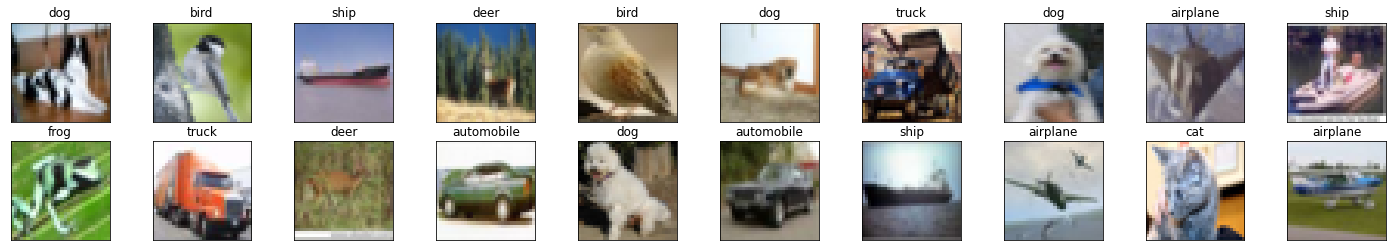

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# show images in train set

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)))
    
images, labels = next(iter(train_loader))
images = images.numpy()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(25, 4))
for i in range(batch_size):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

In [41]:
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.PReLU())
    
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.PReLU(),
                                   nn.MaxPool2d(2))
    
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.PReLU())

        self.conv4 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.PReLU(),
                                   nn.MaxPool2d(2))
        
        self.conv5 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.PReLU())

        self.conv6 = nn.Sequential(nn.Conv2d(256, 512, 3, padding=1),
                                   nn.BatchNorm2d(512),
                                   nn.PReLU(),
                                   nn.MaxPool2d(2))

        self.fc1 = nn.Sequential(nn.Linear(512 * 4 * 4, 2000),
                                 nn.BatchNorm1d(2000),
                                 nn.PReLU(),
                                 nn.Dropout(0.2))
        
        self.fc2 = nn.Sequential(nn.Linear(2000, 500),
                                 nn.BatchNorm1d(500),
                                 nn.PReLU(),
                                 nn.Dropout(0.2))

        self.fc3 = nn.Sequential(nn.Linear(500, 10),
                                 nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    
model = Net()
    
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

model

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): MaxPool2d

In [42]:
# Train

epochs = 8
min_loss = np.Inf

for i in range(epochs):
    ###########
    ###Training
    ###########
    train_loss = 0
    model.train()
    for image, label in train_loader:
        if train_on_gpu:
            model.cuda()
            image, label = image.cuda(), label.cuda()
        optimizer.zero_grad()
        log_y = model(image)
        loss = criterion(log_y, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * image.size(0)
        
    train_loss = train_loss / len(train_loader.dataset)
    #############
    ###Validation
    #############
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for image, label in val_loader:
            if train_on_gpu:
                model.cuda()
                image, label = image.cuda(), label.cuda()
            log_y = model(image)
            loss = criterion(log_y, label)
            val_loss += loss.item() * image.size(0)
    
        val_loss = val_loss / len(val_loader.dataset)
        
        print(f'Epoch: {i+1}/{epochs}, Train loss: {train_loss:>3}, Validation loss: {val_loss:>3}')
        
        if val_loss < min_loss:
            print(f'Saving model, previous loss: {min_loss:>3}, new loss: {val_loss:>3}')
            torch.save(model.state_dict(), 'cifar_model.pt')
            min_loss = val_loss

Epoch: 1/8, Train loss: 0.9877693212151527, Validation loss: 0.17462821625471114
Saving model, previous loss: inf, new loss: 0.17462821625471114
Epoch: 2/8, Train loss: 0.6457808273077011, Validation loss: 0.1416995432674885
Saving model, previous loss: 0.17462821625471114, new loss: 0.1416995432674885
Epoch: 3/8, Train loss: 0.49574786275625227, Validation loss: 0.15273030527234077
Epoch: 4/8, Train loss: 0.3829243002235889, Validation loss: 0.11439682848453522
Saving model, previous loss: 0.1416995432674885, new loss: 0.11439682848453522
Epoch: 5/8, Train loss: 0.2798605802126229, Validation loss: 0.11478455429673196
Epoch: 6/8, Train loss: 0.20109755830615758, Validation loss: 0.11167731053829193
Saving model, previous loss: 0.11439682848453522, new loss: 0.11167731053829193
Epoch: 7/8, Train loss: 0.15445260045863687, Validation loss: 0.1146288574591279
Epoch: 8/8, Train loss: 0.12995699833687394, Validation loss: 0.12219476488158107


In [43]:
model.load_state_dict(torch.load('cifar_model.pt'))

<All keys matched successfully>

In [44]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
total = 0
correct = 0
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    total += target.size(0)
    correct += pred.eq(target).sum().item()

# average test loss
test_loss = test_loss/len(test_loader.dataset)
accuracy = 100.*correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss}, Accuracy: {accuracy}%')

Test Loss: 0.5861511562820524, Accuracy: 81.85%


In [45]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

equals = preds == labels.numpy()
print(preds)
print(labels.numpy())
print(np.mean(equals))

[3 8 8 0 6 6 9 4 3 1 0 9 5 7 9 8 5 7 8 6]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]
0.9
